In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, HTML

In [3]:
%matplotlib inline

In [83]:
np.set_printoptions(linewidth=150)

In [4]:
df = pd.read_csv("EThOSCSV_201803.csv")

In [5]:
# TODO Can I prevent global namespace pollution by having everything inside let-clauses?

In [6]:
def isphd(elem):
    """ Return true if elem["Qualification"] is a PhD. """
    q = elem["Qualification"]
    if type(q) == str:
        qred = q.strip().lower()
        if ("ph.d" in qred or "dphil" in qred or "phd" in qred):
            return True
    return False

In [7]:
dfphd = df[df.apply(isphd, axis=1)]

In [8]:
counts_by_year = dfphd.Date.value_counts().sort_index()

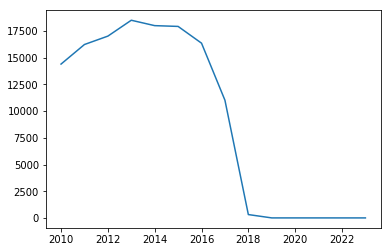

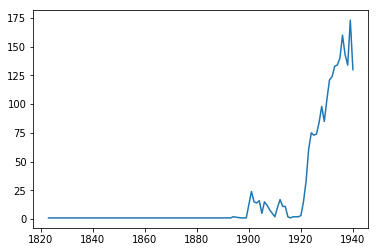

In [9]:
plt.figure()
counts_by_year[2010:].plot()
plt.figure()
counts_by_year[:1940].plot()

In [10]:
late_cutoff = 2015
early_cutoff = 1925
counts_by_year = counts_by_year[early_cutoff:late_cutoff]
dfphd = dfphd[(early_cutoff <= dfphd.Date) & (dfphd.Date <= late_cutoff)]

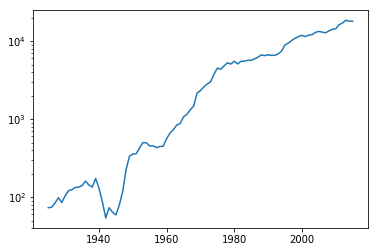

In [11]:
plt.figure()
plt.semilogy(counts_by_year)

In [12]:
counts_by_yearandinst = dfphd.groupby(["Institution", "Date"]).size().unstack("Institution").fillna(0.0)
counts_by_yearandinst = counts_by_yearandinst.sort_values(late_cutoff, axis="columns", ascending=False)
instratios_by_year = counts_by_yearandinst.divide(counts_by_year, axis="index")

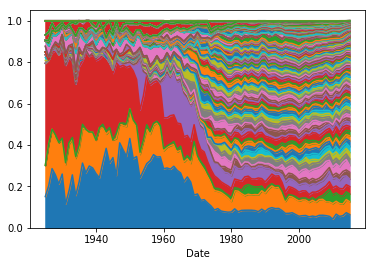

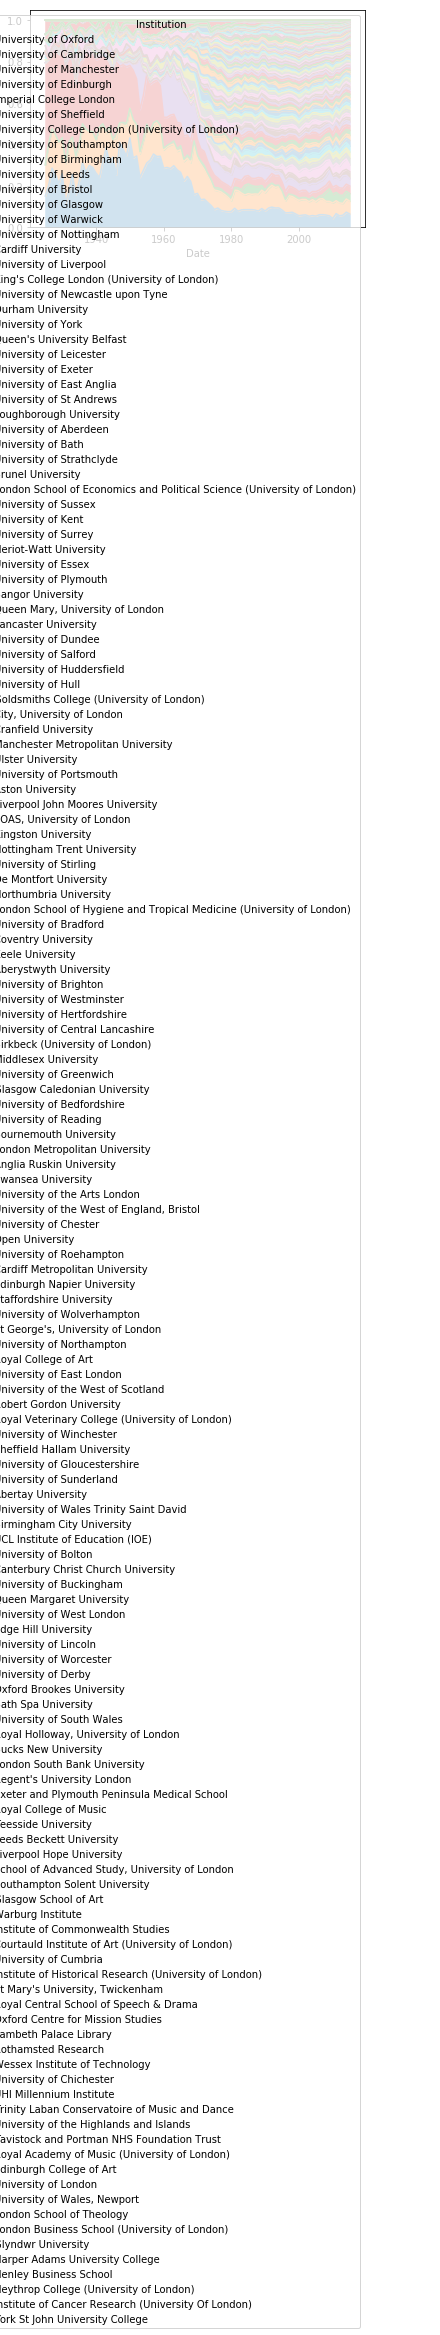

In [13]:
# TODO Fix legend
instratios_by_year.plot.area(legend=False)
instratios_by_year.plot.area(legend=True)

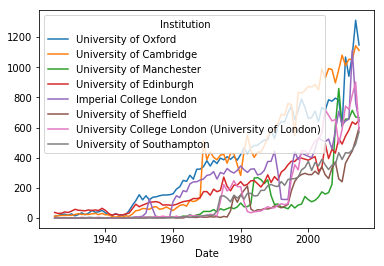

In [14]:
counts_by_yearandinst.iloc(1)[:8].plot()

In [369]:
def splitstr(s):
    """ For a string, remove most punctuation, lower case, and split into words. Return the words.
    """
    puncts = '!"&\'(),./:;<=>?[\\]`{|}-'
    return s.lower().translate(str.maketrans('', '', puncts)).split()

def filter_punctuationwords(l):
    """ Take a list of strings, filter out prepositions, articles, and other boring words. """
    verbotens = ["the", "a", "in", "on", "of", "at", "as", "so", "and", "or", "for", "to", "with", "an", "by", "it", "from", "its", "their", "them", "into", "onto"]
    return tuple(s for s in l if s not in verbotens)
# TODO Add combining plurals and singulars?

In [370]:
dfphd["Words"] = dfphd["Title"].apply(splitstr).apply(filter_punctuationwords)

In [371]:
def get_example_titles(word, n=1):
    titles_with_word = dfphd[dfphd["Words"].apply(lambda x: word in x)]["Title"]
    examples = tuple(titles_with_word.sample(n).values)
    return examples

In [372]:
wordcounts_by_year = dfphd.groupby("Date")["Words"].apply(
    lambda x: pd.Series(np.concatenate(x.tolist())).value_counts()
).unstack("Date").fillna(0.0)

In [373]:
total_wordcounts = wordcounts_by_year.sum(axis=1)
order = (-total_wordcounts).argsort()
total_wordcounts = total_wordcounts[order]
wordcounts_by_year = wordcounts_by_year.reindex(total_wordcounts.index)

In [374]:
wordrates_by_year = wordcounts_by_year.divide(counts_by_year, axis="columns")

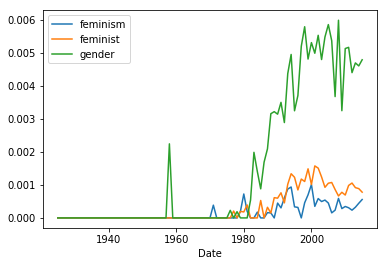

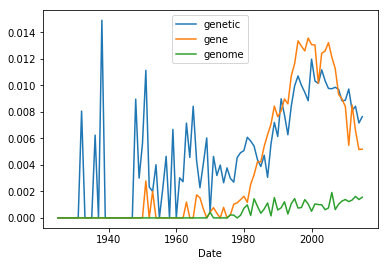

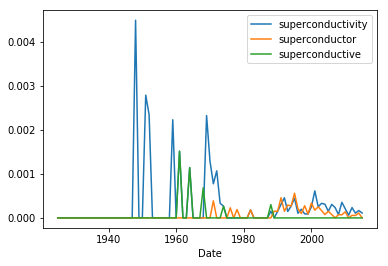

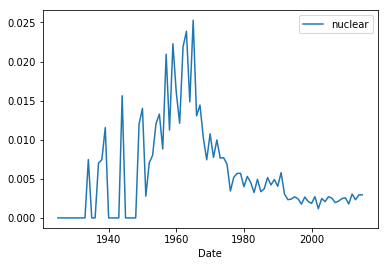

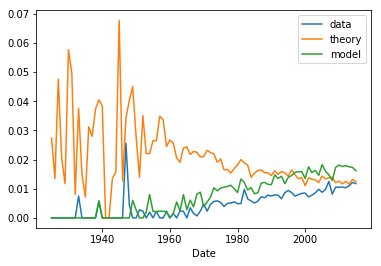

In [381]:
wordsets = (
    ["feminism", "feminist", "gender"],
    ["genetic", "gene", "genome"],
    ["superconductivity", "superconductor", "superconductive"],
    ["nuclear"],
    ["data", "theory", "model"]
)
for s in wordsets:
    wordrates_by_year.T[s].plot()

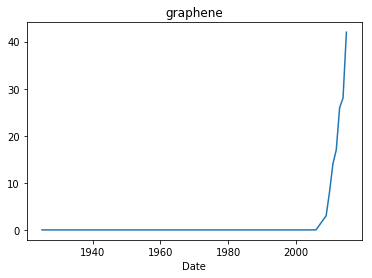

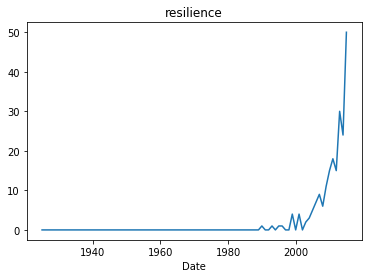

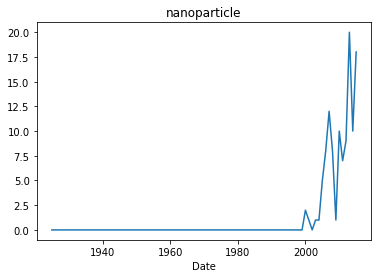

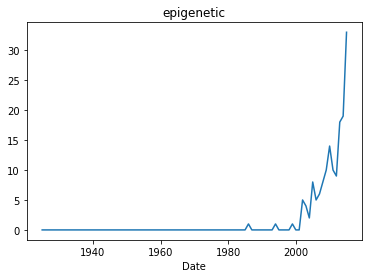

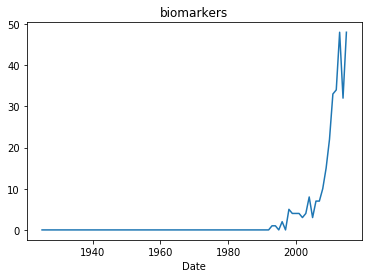

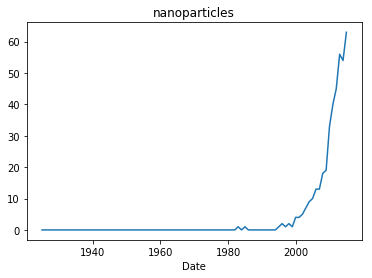

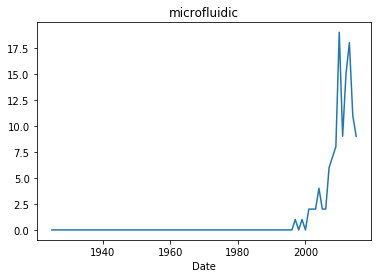

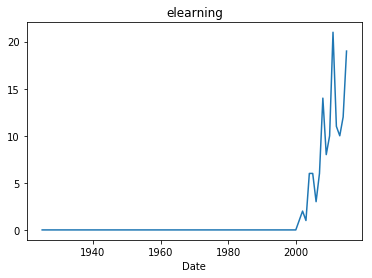

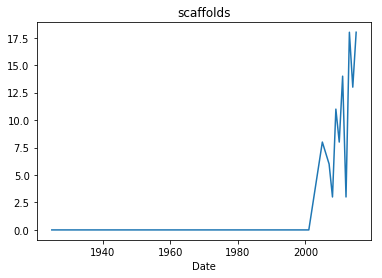

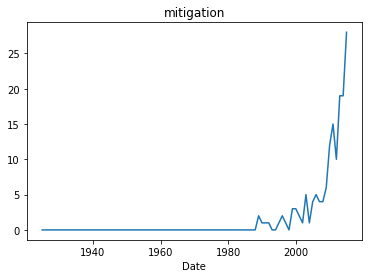

In [563]:
# TODO For each of the top words, get related words that it appears with, and example titles from the top years. 
M = wordcounts_by_year[total_wordcounts > 100].T
stds = (M.std()/M.mean()).sort_values(ascending=False)
topwords = stds.index[:10]
for w in topwords:
    fig = plt.figure()
    M[w].plot()
    plt.title(w)

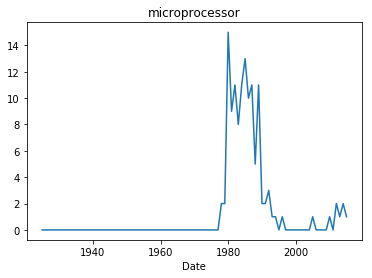

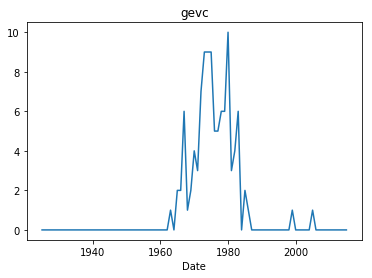

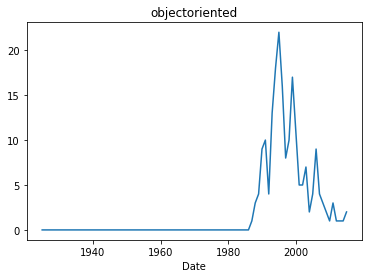

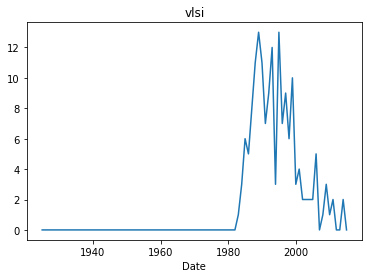

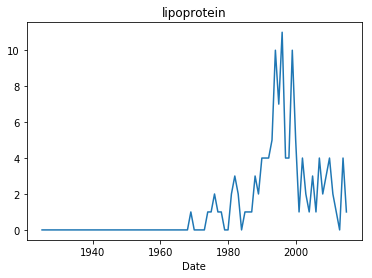

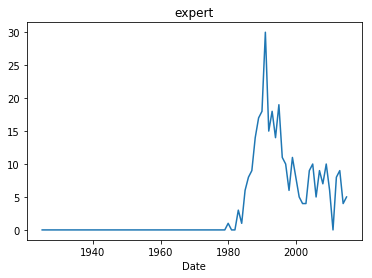

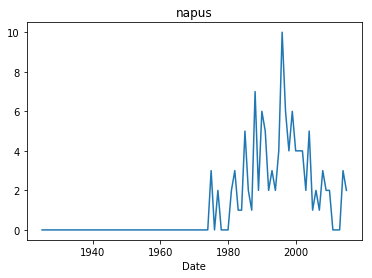

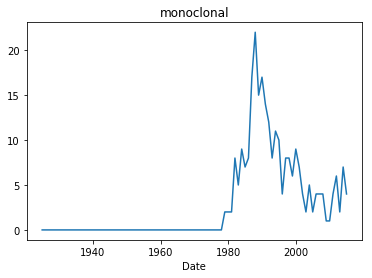

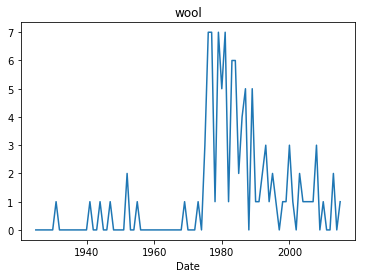

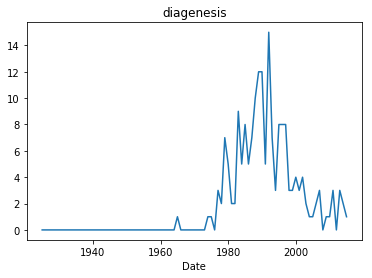

In [596]:
# TODO For each of the top words, get related words that it appears with, and example titles from the top years. 
M = wordcounts_by_year[(total_wordcounts > 100) & (wordcounts_by_year.T.median() > -1) & (total_wordcounts > 3.0*wordcounts_by_year.T.loc[2000:late_cutoff, :].sum())].T
stds = (M.std()/M.mean()).sort_values(ascending=False)
topwords = stds.index[:10]
for w in topwords:
    fig = plt.figure()
    M[w].plot()
    plt.title(w)

In [594]:
total_wordcounts, wordcounts_by_year.T.loc[2000:late_cutoff, :].sum()

(study                                                       31241.0
 studies                                                     23901.0
 development                                                 18658.0
 analysis                                                    18512.0
 investigation                                               13038.0
 using                                                       11941.0
 role                                                        11805.0
 systems                                                     11402.0
 some                                                        10080.0
 effects                                                      9613.0
 control                                                      8444.0
 modelling                                                    8434.0
 design                                                       8240.0
 synthesis                                                    8182.0
 human                            

In [377]:
# TODO Make a graph of which words appear together, find groups of related terms in it
# to get labels for things like research fields.
# Then study how different institutions focus on different fields at different times.

In [378]:
# TODO Can I find correlations between words in titles at institutions, and their university rankings?
# Suggestion: https://www.leidenranking.com/ranking/2019/chart

In [379]:
print(total_wordcounts[10000], total_wordcounts.index[10000])

33.0 1986


In [380]:
samples = 100000
counter = 0
mainwords_number = 1000
mainwords = total_wordcounts.index[:mainwords_number]
cooccurence = pd.DataFrame(0.0, index=mainwords, columns=mainwords)
for words in dfphd["Words"]:
    words = tuple(filter(lambda w: w in mainwords, words))
    cooccurence.loc[words, words] += 1.0
    counter += 1
    if counter > samples:
        break

In [406]:
# TODO Should I rather make a bidirectional graph with different weights going two ways?
#      If I normalize by only row/column, then each value is the frequency of one word appearing given another.
#      The problem with this is that rows/columns can become dominated by very rare or very common words.
#diag_sqrt = np.sqrt(total_wordcounts[mainwords])
#cooccurence = cooccurence.divide(diag_sqrt, axis=0).divide(diag_sqrt, axis=1)
D = np.diag(cooccurence.values)
ones = np.ones(D.shape)
DD = np.outer(D, ones) + np.outer(ones, D)
cooccurence = 2*cooccurence.divide(DD)

In [407]:
import networkx as nx

In [408]:
adjmat = np.array(cooccurence.values)  # Makes a copy, to avoid modifying the original.
np.fill_diagonal(adjmat, 0.0)
g = nx.from_numpy_matrix(adjmat)

In [409]:
labels = {i: cooccurence.index[i] for i in range(len(cooccurence.index))}
g = nx.relabel_nodes(g, labels)

In [410]:
testword = "study"
d = dict(g.adjacency())[testword]
sorted([(v["weight"], k) for k, v in d.items()], reverse=True)[:100]

[(0.18810102504491177, 'case'),
 (0.12052995661859538, 'comparative'),
 (0.06016165319556704, 'development'),
 (0.0568868514273807, 'reference'),
 (0.054600606673407485, 'education'),
 (0.05238459019971625, 'between'),
 (0.05020624631703005, 'experimental'),
 (0.04652178661133559, 'social'),
 (0.04325062599590257, 'english'),
 (0.04005805515239477, 'using'),
 (0.037860444640105656, 'management'),
 (0.03653949489521763, 'use'),
 (0.03449449676614093, 'special'),
 (0.03319696084161309, 'change'),
 (0.032995183932779996, 'some'),
 (0.031742354031510656, 'england'),
 (0.03143893591293833, 'school'),
 (0.03107658157602664, 'role'),
 (0.03102223883386283, 'systems'),
 (0.03024747937671861, 'policy'),
 (0.030241286863270777, 'application'),
 (0.028554431885782272, 'industry'),
 (0.028342857142857142, 'british'),
 (0.02813705468572725, 'factors'),
 (0.02757132582114601, 'relationship'),
 (0.027417027417027416, 'critical'),
 (0.027188562053205204, 'learning'),
 (0.027095877721167207, 'process')

In [411]:
import community as louvain

In [412]:
dendrogram = louvain.generate_dendrogram(g)

In [415]:
partition = louvain.partition_at_level(dendrogram, 1)
communities = pd.DataFrame({"Community": tuple(partition.values())}, index=partition.keys()).groupby("Community").groups
communities = tuple(map(tuple, communities.values()))
print(len(communities))
print([len(c) for c in communities])
[print(c) for c in communities]

3
[417, 220, 363]
('study', 'development', 'case', 'social', 'reference', 'between', 'theory', 'management', 'new', 'education', 'evaluation', 'impact', 'policy', 'english', 'british', 'learning', 'health', 'towards', 'early', 'special', 'uk', 'change', 'england', 'process', 'practice', 'political', 'assessment', 'comparative', 'information', 'through', 'children', 'language', 'politics', 'critical', 'economic', 'work', 'history', 'community', 'relationship', 'life', 'state', 'culture', 'evolution', 'identity', 'international', 'industry', 'within', 'environmental', 'women', 'public', 'law', 'south', 'britain', 'century', 'quality', 'understanding', 'context', 'particular', 'implications', 'risk', 'strategies', 'care', 'construction', 'urban', 'school', 'developing', 'european', 'environment', 'knowledge', 'technology', 'local', 'contemporary', 'people', 'primary', 'relations', 'cultural', 'national', 'experience', 'planning', 'exploration', 'perspective', 'northern', 'art', 'framework

[None, None, None]

In [418]:
wordscores = pd.DataFrame({"word": total_wordcounts.index}).set_index("word")
for i, c in enumerate(communities):
    wordscores[i] = cooccurence.loc[:, c].sum(axis=1)
#wordscores.columns = ["Humanities", "Experimental", "Theory", "Bio"]
wordscores.columns = ["Humanities", "Bio", "Science"]
wordscores = wordscores.fillna(0.0)

In [434]:
for c in ["Humanities", "Bio", "Science"]:
    print(c)
    print(wordscores.sort_values(c, ascending=False)[:20])

Humanities
             Humanities       Bio   Science
word                                       
case           6.762936  0.482581  0.995820
education      6.663378  0.362045  0.566990
reference      6.613690  0.996046  1.249045
policy         6.048497  0.330542  0.683511
social         5.891548  0.693352  0.752292
school         5.799141  0.455613  0.514544
special        5.729130  0.774592  0.949437
united         5.400067  0.312216  0.512542
health         5.362756  0.856669  0.653726
study          5.352746  1.159014  2.063745
management     5.251017  0.658373  1.486773
teachers       5.214618  0.303207  0.361434
english        5.213161  0.338474  0.642039
practice       5.188569  0.455086  0.645284
public         5.155542  0.252489  0.563513
political      5.131586  0.244015  0.408262
england        5.112399  0.454244  0.596510
change         5.095728  0.507394  0.813917
schools        5.092233  0.212547  0.415443
comparative    5.063290  0.756281  0.781339
Bio
             Huma

In [419]:
for c in wordscores.columns:
    print("Computing title scores for {}.".format(c))
    # The python sum function is significantly faster here than a sub-DataFrame.sum().
    dfphd[c] = dfphd["Words"].apply(lambda ws: sum(wordscores.loc[w, c] for w in ws)/(len(ws) if len(ws) > 0 else 1))

Computing title scores for Humanities.
Computing title scores for Bio.
Computing title scores for Science.


In [543]:
for c in ["Humanities", "Bio", "Science"]:
    print(c)
    subdf = dfphd[["Title", c]].sort_values(c, ascending=False).set_index("Title")[:20]
    display(HTML(subdf.to_html()))

Humanities


,Humanities
Title,
On reference,6.613690
The impact of education on political development,5.287715
Learning from experience : the case study of a primary school,5.175110
Understanding in education,5.147205
Professional education in social work; learning for practice,5.074212
The learning and teaching of English as a foreign language : a case study of a Saudi secondary school,5.071817
Learning in social work practice,5.066324
Policy formation in the European Union : the case of education policy,5.025873
The Chinese community in Britain : with special reference to housing and education,5.006747


Bio


,Bio
Title,
Mechanisms of cell growth,3.350748
Gene therapy for human cancer,3.337071
Regulation of T cell growth,3.285570
Cell membrane proteins,3.233655
Studies of the changes in protein expression in human heart disease,3.228282
Muscle protein metabolism,3.193108
Regulation of liver cell growth,3.154283
Molecular analysis of gene expression in rat brain,3.137107
Regulation of gene expression during T cell development,3.125352


Science


,Science
Title,
Applications of magnetic resonance,4.156298
Optical Properties of Thin Metal Films,4.154060
Magnetic resonance,4.143210
Magnetic resonance,4.143210
Magnetic resonance in high field,4.077954
Some applications of magnetic resonance,4.059513
Design and application of fibre laser systems for gas spectroscopy,4.036874
Investigations in High Resolution Spectroscopy Using Digital Techniques,4.000109
The modelling and design of a fibre laser system with application to gas spectroscopy,3.987217


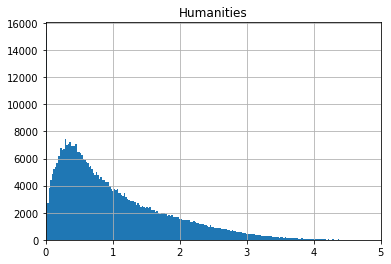

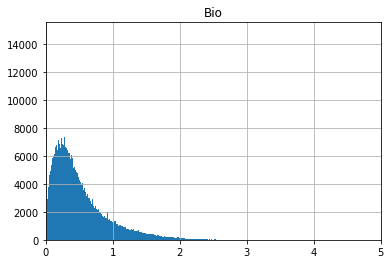

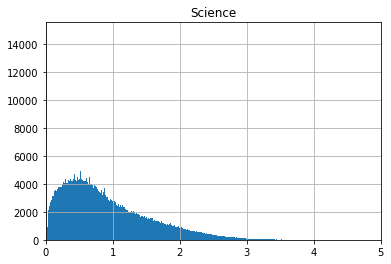

<Figure size 432x288 with 0 Axes>

In [448]:
for c in wordscores.columns:
    dfphd[c].hist(bins=300)
    plt.title(c)
    plt.xlim(0.0, 5.0)
    plt.figure()

In [449]:
dfphd[wordscores.columns].corr()

,Humanities,Bio,Science
Humanities,1.000000,-0.076961,-0.055008
Bio,-0.076961,1.000000,0.203172
Science,-0.055008,0.203172,1.000000


In [467]:
dfphd["Main field"] = dfphd[wordscores.columns].idxmax(axis=1)

(-0.05, 2.55)

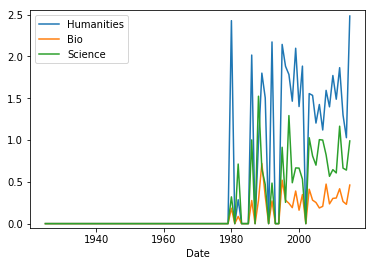

<Figure size 432x288 with 0 Axes>

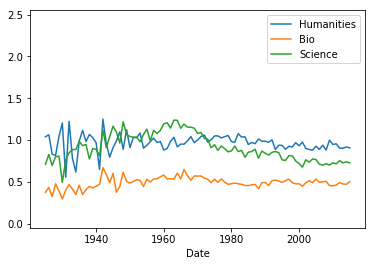

<Figure size 432x288 with 0 Axes>

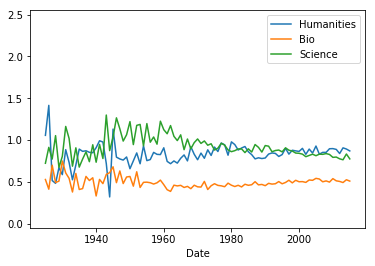

<Figure size 432x288 with 0 Axes>

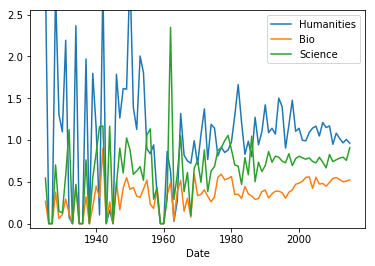

<Figure size 432x288 with 0 Axes>

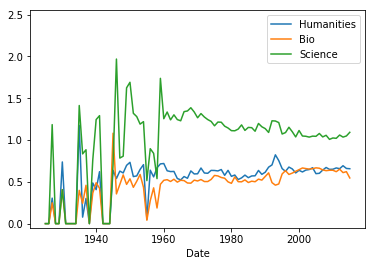

In [463]:
meanscores_by_yearandinst = dfphd.groupby(["Institution", "Date"]).mean().unstack("Institution").fillna(0.0).reorder_levels([1, 0], axis=1)
ylims = (-0.05, 2.55)
meanscores_by_yearandinst["Glasgow School of Art"].plot()
plt.ylim(*ylims)
plt.figure()
meanscores_by_yearandinst["University of Oxford"].plot()
plt.ylim(*ylims)
plt.figure()
meanscores_by_yearandinst["University of Cambridge"].plot()
plt.ylim(*ylims)
plt.figure()
meanscores_by_yearandinst["University of Birmingham"].plot()
plt.ylim(*ylims)
plt.figure()
meanscores_by_yearandinst["Imperial College London"].plot()
plt.ylim(*ylims)

(-0.05, 1.05)

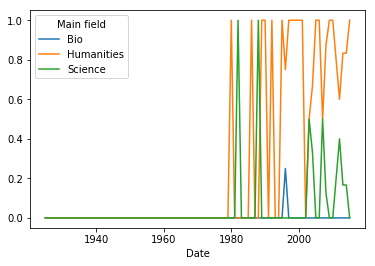

<Figure size 432x288 with 0 Axes>

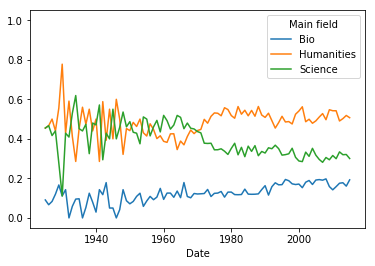

<Figure size 432x288 with 0 Axes>

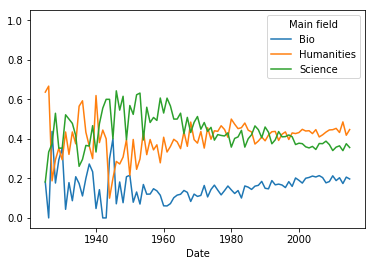

<Figure size 432x288 with 0 Axes>

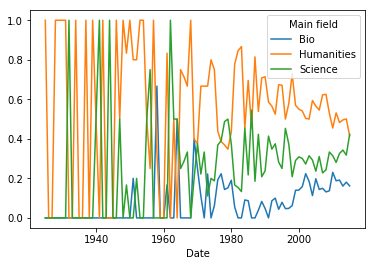

<Figure size 432x288 with 0 Axes>

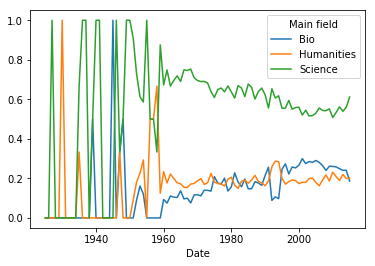

In [520]:
fieldcounts_by_yearandinst = dfphd.groupby(["Institution", "Date", "Main field"]).size().unstack(("Institution", "Main field")).fillna(0.0)
fieldratios_by_yearandinst = (fieldcounts_by_yearandinst/counts_by_yearandinst).fillna(0.0)
fieldratios_by_yearandinst = fieldratios_by_yearandinst.reindex(sorted(fieldratios_by_yearandinst.columns), axis=1)
ylims = (-0.05, 1.05)
fieldratios_by_yearandinst["Glasgow School of Art"].plot()
plt.ylim(*ylims)
plt.figure()
fieldratios_by_yearandinst["University of Oxford"].plot()
plt.ylim(*ylims)
plt.figure()
fieldratios_by_yearandinst["University of Cambridge"].plot()
plt.ylim(*ylims)
plt.figure()
fieldratios_by_yearandinst["University of Birmingham"].plot()
plt.ylim(*ylims)
plt.figure()
fieldratios_by_yearandinst["Imperial College London"].plot()
plt.ylim(*ylims)

In [547]:
pd.DataFrame(dfphd[(dfphd["Institution"] == "Glasgow School of Art") & (dfphd["Date"] > 1980)].sort_values("Science", ascending=False)["Title"]).set_index("Title")

""
Title
An empirical investigation into the design methodology of iconic buildings
The certainty of chance : using novelistic reflexivity to design aspects of practice
An investigation into the free-form digital modelling on architectural designing : a comparative study across expertise and domain
The use of modelscope techniques in examining the legibility of architectural interior space and as a tool in the architectural design process
The application of perception theory in architecture and urban design : with particular reference to Liberation Square in Cairo
The potential of 3D visualisation technology in art and design education
The utilisation of non-clothing materials within the fashion system
Creating screen-based multiple state environments : investigating systems of confutation
Taking account of age and generation effects : implications for inclusive design


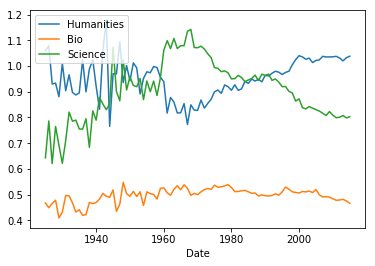

In [426]:
meanscores_by_year = dfphd.groupby(["Date"]).mean().fillna(0.0)
meanscores_by_year.plot()

In [157]:
# TODO Fun experiment: Find titles where the words are very far apart in graph-distance, i.e. exceptional titles.